# Você deveria estar calibrando seu modelo (ou não?)

## Introdução

Se você é um(a) cientista de dados, provavelmente sabe que a maior parte dos algoritmos de classificação do Scikit-Learn tem dois métodos: `.predict()` e `.predict_proba()`, em que o primeiro devolve um número inteiro (0 ou 1 no caso binário) enquanto o segundo devolve um número real (*entre* 0 e 1 no caso binário).

O que alguns cientistas às vezes não percebem é que este número em [0,1] não necessariamente é uma *probabilidade*, no sentido matemático, mas somente um score: ou seja, se uma entrada $x_1$ tem previsão 0.3 e outra $x_2$ tem previsão 0.4, então é verdade que $x_2$ tem maior probabilidade de ser 1 do que $x_1$; mas **não** quer dizer que esta probabilidade em si seja 0.4.

> Scores nos permitem *ordenar*; probabilidades são exemplos de scores, mas possuem estrutura extra.

No contexto de modelos de classificação, o processo de **calibração de modelos** é o que permite que você interprete o output `0.4` do seu `model.predict_proba(X)` como querendo dizer que "existe uma probabilidade de 40% de $y$ ser igual a 1".

## Para o apressado

Ver a seção de conclusão, que contém um passo-a-passo de como realizar a calibração.

## Contexto matemático

Consideremos o cenário de duas variáveis aleatórias $(X,Y)$ distribuidas conjuntamente, em que $X$ assume valores reais e $Y$ assume valores em $\{0,1\}$.

O problema de classificação binária se resume a encontrar uma função $f$ tal que

$$f(x) = \mathbb P(Y=1|X=x),$$

isto é, a probabilidade de $Y$ ser 1 quando a variável $X$ assume o valor $x$. 

Na prática, nós não temos acesso a $\mathbb P$, e tentamos encontrar uma aproximação (que chamaremos de $\widehat{\mathbb P}$). 

O processo de treinar um modelo de classificação nos dá acesso a uma função $s$ (que chamaremos de **função score**) tal que

$$s(x) = \widehat{\mathbb P}(Y=1|X=x)$$

Disso, o processo de calibração se propõe a identificar uma função $\phi$ que converte scores em probabilidades:

$$\boxed{\phi \circ s \approx f}$$

ou, em outras palavras, 

$$\mathbb P(Y=1|X=x) \approx \phi(\widehat{\mathbb P}(Y=1|X=x))$$

## Mas... scores não são suficientes?

Muitas vezes, sim:
* Em crédito, um banco tem uma lista de pessoas pedindo crédito, e precisa ordená-las das menos às mais propensas a ser inadimplentes no pagamento deste crédito. Aqui, um modelo de score é o bastante
* Num site de e-commerce que queira recomendar produtos ao seu cliente, ele não precisa saber exatamente a probabilidade do cliente clicar e comprar um produto; somente é necessário saber quais produtos são mais propensos que outros.

Em outras situações, como fraude ou seguros, isso deixa de ser verdade e probabilidades reais são necessárias.

> Decida se no seu caso de uso / aplicação você precisa mesmo de calibração, ou se scores bastam.

## Como realizar uma análise de calibração?

Existem duas etapas:
1. **Diagnóstico**: entender se seu modelo está mal-calibrado ou não
2. **Calibração**: rodar um algoritmo de calibração.

Para o diagnóstico, existem **4 métricas** importantes a considerarmos:
1. Brier score 
2. Expected Calibration Error (ECE)
3. Curva de calibração
4. Brier score estratificado (para problemas desbalanceados)

Para a calibração, por outro lado, usaremos **2 algoritmos**:
1. Regressão isotônica, que se propõe a melhorar o Brier score
2. Calibração via "underbagging" (undersampling+bagging), discutida no artigo [1] de Wallace & Dahabreh.

## Montar base de exemplo e alguns modelos

Vamos instanciar três modelos: um gradient boosting, uma random forest, e uma regressão logística.

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


# criar dados
X, y = make_classification(n_samples=20000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# instanciar alguns modelos 
gb = HistGradientBoostingClassifier(max_depth=5, random_state=1).fit(X_train, y_train)
rf = RandomForestClassifier(max_depth=5, random_state=2).fit(X_train, y_train)
lr = LogisticRegression().fit(X_train, y_train);

## Parte 1: diagnóstico

Suponha que, para um ponto $X=x$ dado, seu score seja de $s(x) = 0.3$. O que significa que essa probabilidade seja de 30%?

A interpretação é: considere todos os pontos (além de $x$) $x_1, x_2, \ldots, x_k$ cujo score é 30%. Então, destes, 30%  devem ter $Y=1$, e os outros $Y=0$.

Se isso for verdade não apenas para o valor 30%, mas qualquer outro, então o modelo está bem calibrado. Afinal, dos pontos com score de 30%, realmente houve 30% com $Y=1$.

Claro que, numa dada amostra, podemos ter quaisquer valores de score: 0.2998, 0.3005, 0.30873 etc. Para conseguirmos pontos o suficiente para estudar se um score de 0.3 é bem calibrado, precisamos agrupar scores próximos em **bins**, como fazemos na hora de construir um histograma.

**Como montar uma curva de calibração:**
* Calcular as previsões do modelo `y_probs`
* Criar bins (segundo alguma estratégia) de scores próximos
* Calcular: quantos % pontos dentro de cada bin tem $Y=1$?
* Calcular: qual a média dos scores dentro de cada bin?

A função `calibration_curve` do Scikit-Learn faz estas etapas para nós:

In [125]:
from sklearn.calibration import calibration_curve

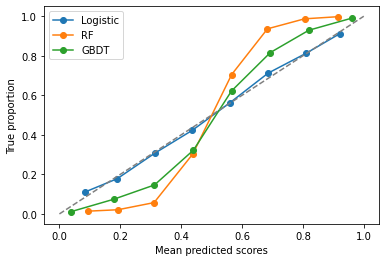

In [126]:
fig, ax = plt.subplots()
models, names = [lr, rf, gb], ['Logistic', 'RF', 'GBDT']
for model, name in zip(models, names):
    y_probs = model.predict_proba(X_test)[:,1]
    proportion_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=8)
    ax.plot(prob_pred, proportion_true, label=name, marker='o')

plt.plot([0,1], color='gray', linestyle='--')
plt.xlabel("Mean predicted scores")
plt.ylabel("True proportion")
plt.legend()
plt.show()

O que podemos inferir destas curvas:
* Regressão logística é bem-calibrada de fábrica
> Isso acontece pois regressão logística é um modelo que explicitamente modela a probabilidade: $$\mathbb P(Y=1|X=x) = \frac{1}{\displaystyle 1 + e^{-w \cdot x}},$$o que pode ser interpretado como sendo um modelo que penaliza tanto performance ruim quanto má calibração ao mesmo tempo.
* Tanto random forests quanto gradient boosted trees possuem uma curva de calibração em formato de "S":
> O formato "S" para random forests pode ser interpretado da seguinte forma. O modelo está sendo otimista demais para scores baixos (e pessimista demais para scores altos). Isso acontece porque o random forest é um voto - uma média - entre várias árvores de decisão; e é difícil que essa média seja 0 (ou 1), porque precisaria de scores menores que zero (ou maiores que 1) para isso acontecer. Em outras palavras, random forests evitarão scores extremamente pequenos ou grandes, e calibração se torna necessária.

### Existem métricas quantitativas para medir calibração?

A métrica mais comunmente citada para calibração é o **Brier score**

$$\boxed{B = \frac{1}{N} \sum_{i=1}^N (y_i - q_i)^2}$$

em que $y_i \in \{0,1\}$ é o label real do i-ésimo ponto, e $q_i \in [0,1]$ é o score previsto, $q_i \equiv s(x_i)$. Basicamente, o Brier score é um nome chique para o erro quadrático médio num problema de classificação.

**Cuidado: o Brier score não nos permite comparar dois algoritmos diferentes**, como regressão logística e random forest. Isso porque o Brier score depende de duas componentes:
1. O quão bom é seu modelo
2. A calibração dele

Esquematicamente,

$$\mbox{Brier} \sim \mbox{Calibração} + \mbox{Performance}$$

Assim, modelos com performances diferentes terão Brier scores diferentes naturalmente.

Por exemplo, no nosso caso atual, a performance dos nossos modelos (medida via a ROC AUC, por exemplo) é:

In [5]:
for model, name in zip(models, names):
    y_probs = model.predict_proba(X_test)[:,1]
    print(f"AUC = {round(roc_auc_score(y_test, y_probs),3)} ({name})")

AUC = 0.798 (Logistic)
AUC = 0.955 (RF)
AUC = 0.981 (GBDT)


Então, para que serve o Brier score?
> **Se fixarmos o modelo** (por exemplo, uma random forest) e somente **mexermos a função de calibração** (que chamamos de $\phi$ na discussão acima), aí sim faz sentido usarmos o Brier score - como a performance está fixa, a variação do Brier score se dará por melhoria de calibração somente.

Em Scikit-Learn, o Brier score pode ser calculado da forma abaixo:

In [6]:
from sklearn.metrics import brier_score_loss

for model, name in zip(models, names):
    y_probs = model.predict_proba(X_test)[:,1]
    print(f"BS = {round(brier_score_loss(y_test, y_probs),3)} ({name})")

BS = 0.183 (Logistic)
BS = 0.118 (RF)
BS = 0.053 (GBDT)


Uma métrica alternativa, que podemos usar diretamente para comparar calibrações, é a **Expected Calibration Error** ou ECE. Citada em [3], ela usa a curva de calibração (ponderada pelo volume em cada bin), segundo a expressão

$$\boxed{\mathrm{ECE} = \sum_{b=1}^B p_b |\bar{q}_b - \bar{y}_b|}$$

em que:
* $p_b$ é a proporção de pontos caindo no bin $b$, ie. $p_b = N_b / N$
* $\bar q_b$ é o score médio no bin $b$,
  $$\bar q_b = \frac{1}{N_b} \sum_{i: i \in b} q_i$$
* $\bar y_b$ é a proporção de $Y=1$'s no bin $b$,
  $$\bar y_b = \frac{1}{N_b} \sum_{i:i \in b} y_i$$

Em outras palavras: o ECE é a **distância média (no sentido $L_1$, e ponderada) de o quanto a curva de calibração se afasta da identidade**.

Abaixo, fazemos uma implementação da ECE. Para isso, precisamos criar uma versão modificada da `calibration_curve` do Scikit-Learn, para termos acesso ao volume por bin.

In [7]:
def calib_curve_proportions(y_true, y_probs, n_bins=10, method='uniform'):
    from sklearn.calibration import calibration_curve
    assert method in ['quantile', 'uniform'], "Unrecognized method"
    
    predictions = pd.DataFrame({
        'label': y_true,
        'scores': y_probs,
        })
    
    predictions = predictions.sort_values('scores')
    
    if method == 'quantile':
        quantiles = [predictions['scores'].quantile(q) for q in np.linspace(0, 1, n_bins+1)] 
        predictions['bins'] = pd.cut(predictions['scores'], quantiles)

    else:
        bins=np.linspace(0, 1, n_bins+1) 
        predictions['bins'] = pd.cut(predictions['scores'], bins)
        
    # we can now aggregate: average y=1 per chunk and average score per chunk
    calibration = predictions.groupby('bins').mean().reset_index(drop=True)
    calibration.columns = ['Fraction of positives', 'Average score']
    
    x, y = calibration['Average score'], calibration['Fraction of positives']
    p = predictions.groupby('bins').\
                   apply(lambda x: len(x)).\
                   values
    p = p/len(y_true)
    
    return x, y, p

In [8]:
def ece(y_true, y_probs, n_bins=10, method='uniform'):
    x, y, p = calib_curve_proportions(y_true, y_probs, n_bins=n_bins, method=method)
    return np.sum(p*np.abs(x - y))

In [9]:
for model, name in zip(models, names):
    y_probs = model.predict_proba(X_test)[:,1]
    print(f"ECE = {round(ece(y_test, y_probs, method='quantile'),3)} ({name})")

ECE = 0.016 (Logistic)
ECE = 0.175 (RF)
ECE = 0.057 (GBDT)


Vemos que essa métrica reflete bem a visão que a regressão logística é mais bem calibrada, com um ECE de ~1/5 em relação ao gradient boosting e ~1/15 em relação à random forest.

Por fim, **para problemas desabalanceados** (em que uma classe é muito mais predominante que a outra), existe uma versão alternativa do Brier score que podemos usar, segundo [1]: o **Brier score estratificado**, dado por

$$\boxed{\mathrm{BS}_1 = \frac{1}{N_1} \sum_{i: y_i = 1} (q_i - 1)^2}$$

$$\boxed{\mathrm{BS}_0 = \frac{1}{N_0} \sum_{i: y_i = 0} (q_i - 0)^2}$$

isto é, os Brier scores de cada uma das classes. Aqui, $N_1$ representa o total de pontos na classe 1, e similarmente para $N_0.$ Veremos na seção abaixo como usar esta métrica.

> No caso balanceado (que é do da base que estamos mexendo), os Brier scores estratificados são basicamente iguais entre si:

In [10]:
def stratified_brier_score(y_true, y_probs):
    dic= {
        1: ((y_probs[y_true==1] - 1)**2).mean(),
        0: ((y_probs[y_true==0])**2).mean()
    }
    
    return pd.DataFrame(dic, index=['Brier'])

In [11]:
for model, name in zip(models, names):
    y_probs = model.predict_proba(X_test)[:,1]
    print(f"Brier estratificado ({name})")
    print("-"*29)
    print(stratified_brier_score(y_test, y_probs).round(3))
    print("="*29)

Brier estratificado (Logistic)
-----------------------------
          1      0
Brier  0.19  0.177
Brier estratificado (RF)
-----------------------------
           1      0
Brier  0.121  0.116
Brier estratificado (GBDT)
-----------------------------
           1      0
Brier  0.051  0.054


# Parte 2: Calibração

Uma vez feito o diagnóstico da calibração do seu modelo, passamos à pergunta seguinte: como calibrá-lo?

O pessoal do Google [4] diz que você não deveria calibrar. Os pontos deles são, essencialmente:
* Calibração simplesmente joga questões estruturais do seu modelo embaixo do tapete
* Adiciona uma camada de complexidade a mais, que precisa ser mantida e testada

Em vez de calibrar, a sugestão deles é de entender - por que o modelo está mal-calibrado? Problemas com os dados? Viés? Regularização muito forte?
> De fato, como vimos acima, regularização em excesso pode levar à pioras na calibração, mas às vezes é um mal necessário; muitas vezes não temos como conseguir mais dados, ou de melhor qualidade, no dia-a-dia.

Como vimos na introdução, o processo de calibração pressupõe o treinamento de uma função $\phi$ que recebe um score $q$ e devolve uma (melhor estimativa de) probabilidade. Chamamos este processo de fixar um modelo e mexer na função de calibração de **"calibração por pós-processamento"**, e existem basicamente duas estratégias:
1. **Paramétrica**, o melhor exemplo sendo Platt (1999) com uma curva logística
2. **Não-paramétrica**, cujo melhor exemplo é o da regressão isotônica via o algoritmo PAV.

Na nossa experiência, **pressupondo que você tem dados o suficiente** (pelo menos 1000 em cada fold de calibração, veja abaixo), **o método não-paramétrico via regressão isotônica performa melhor**. 

O Scikit-Learn oferece uma interface simples para calibração, via o objeto `CalibratedClassifierCV`. Dado um objeto `model` pre-treinado, a interface é:

```
calibrator = CalibratedClassifierCV(base_estimator=model, cv='prefit', method='isotonic')
calibrator.fit(X_calib, y_calib)
```

onde `X_calib` e `y_calib` são uma base separada da de treino e teste, somente para fim de calibração.

### Calibrando nossos modelos

Primeiro, separamos uma base de calibração avulsa:

In [12]:
def train_calib_test_split(X, y, train_size=0.5, calib_size=0.25, test_size=0.25, random_state=1):

    from sklearn.model_selection import train_test_split
    assert train_size + calib_size + test_size == 1, "Sizes do not sum to 1"
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size,
                                                                stratify=y, random_state=random_state)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=calib_size/(train_size+calib_size), 
                                                      stratify=y_train_val, random_state=random_state+12)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
X_train, X_calib, X_test, y_train, y_calib, y_test = \
    train_calib_test_split(X, y,
                           train_size=0.6,
                           calib_size=0.15,
                           test_size=0.25,
                           random_state=42)

Treinamos os modelos somente na base de treino:

In [14]:
models = [
    HistGradientBoostingClassifier(max_depth=5, random_state=1).fit(X_train, y_train),
    RandomForestClassifier(max_depth=5, random_state=2).fit(X_train, y_train),
    LogisticRegression().fit(X_train, y_train)
]

E por fim calibramos:

In [15]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_models = []
for model in models:
    calibrator = CalibratedClassifierCV(base_estimator=model, cv='prefit', method='isotonic')
    calibrator.fit(X_calib, y_calib)
    calibrated_models.append(calibrator)

Vejamos os resultados segundo a curva de calibração e as métricas que discutimos **no conjunto de teste**:

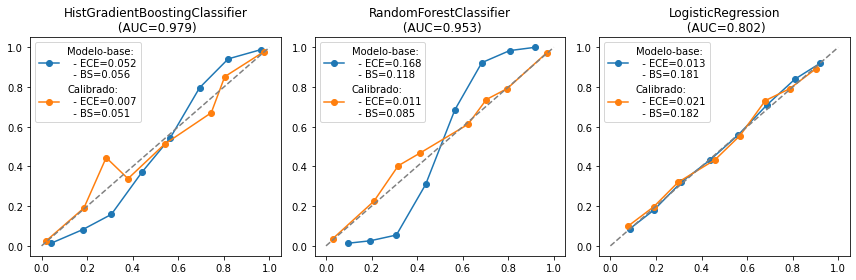

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

for axx, model, calibrated_model in zip(ax, models, calibrated_models):
    
    model_name = type(model).__name__

    ###
    # base model: metrics
    y_probs = model.predict_proba(X_test)[:,1]
    AUC = roc_auc_score(y_test, y_probs)
    ECE = ece(y_test, y_probs).round(3)
    BS = brier_score_loss(y_test, y_probs).round(3)
    
    # base model: calibration curve
    proportion_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=8)
    axx.plot(prob_pred, proportion_true, label=f"Modelo-base:\n  - {ECE=}\n  - {BS=}", marker='o')
    
    ####
    # calibrated model: metrics
    y_probs = calibrated_model.predict_proba(X_test)[:,1]
    ECE = ece(y_test, y_probs).round(3)
    BS = brier_score_loss(y_test, y_probs).round(3)
    # calibrated model: calibration curve
    proportion_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=8)
    axx.plot(prob_pred, proportion_true, label=f"Calibrado:\n  - {ECE=}\n  - {BS=}", marker='o')

    axx.legend()
    axx.plot([0,1], color='gray', linestyle='--')

    axx.set_title( f"{model_name}\n (AUC={round(AUC,3)})")
plt.tight_layout()
plt.show()

Essa análise nos permite obter alguns insights:
* Entre os modelos pré-calibração, a regressão logística é a melhor calibrada segundo ECE, mas é a menos performante, com a ROC AUC de teste mais baixa;
* O processo de calibração *piorou* a regressão logística (o ECE aumentou) - isso é comum acontecer, pois a regressão logística já é naturalmente bem-calibrada
* O processo de calibração foi muito efetivo para GBDT e Random Forest neste exemplo:
  * Para HistGradientBoost, o ECE reduziu em 86% e o Brier Score em 8%, com ECE final em 0.007
  * Para RandomForest, o ECE reduziu em 93% e o Brier score em 27%, com ECE final em 0.011
  
Claramente, o modelo de HistGradientBoostingClassifier calibrado foi nosso melhor, com a maior performance e a melhor calibração!

### E as métricas?

Começando pela conclusão: **podemos usar as métricas de ROC AUC, KS e Avg. Precision do modelo original (sem calibrar) sem grandes problemas**.

É preciso cuidado para entender o porquê disso. Deixamos essa discussão para o Apêndice no fim deste artigo.

# Parte 3: tudo de novo, em casos desbalanceados

Para nós, um problema desbalanceado é aquele em que pelo menos um dos itens abaixo é verdadeiro:
* Uma das classes tem presença muito menor que a outra (eg. em proporção 99:1 ou 999:1)
* O número absoluto de pontos de uma das classes é muito baixo (por exemplo, na ordem de dezenas ou centenas)

Nesse caso,
(1) o processo de construir bins é menos confiável, com poucos ou nenhum ponto da classe de minoria por bin
(2) scores podem se concentrar em valores muito baixos ou muito altos
(3) temos que tomar cuidado com métricas sensíveis ao desbalanço de classe

Como indicado em [1]:

> Class probability estimates attained via supervised learning in imbalanced scenarios systematically underestimate the probabilities for minority class instances, despite ostensibly good overall calibration

O ponto principal aqui é: a calibração geral pode parecer boa mesmo que nossas estimativas para a classe de minoria estejam ruins (elas são mascaradas pelo desbalanço). Novamente, [1] reitera que

> Probability estimates for the minority instances in imbalanced datasets are unreliable, and methods for mitigating class imbalance for classification do not automatically fix calibration.

O approach sugerido pelos autores em [1] se baseia nas seguintes observações:

1. O processo de **random undersampling** (sub-amostragem aleatória?) da classe de maioria na hora da calibração resolve a questão de desbalanço, mas pode introduzir viés dada a natureza aleatória do undersampling;
2. Nisso, **bagging** (bootstrap aggregating) resolve a questão do viés ao criar diferentes amostras de boostrapping para a classe undersampled, e então agregando os resultados

Chamaremos esta estratégia de **underbagging** (ou de Wallace-Dahabreh).

### Resumo da nossa estratégia (que mostraremos abaixo)

1. Treine um bom modelo adequado ao desbalanço (por exemplo, usando `class_weight`) e verifique o Brier score estratificado dele / performance
2. Use underbagging com o modelo, e verifique o Brier score estratificado dele / performance

### Testando difentes estratégias

Primeiro, criamos uma base com proporção de 99:1:

In [17]:
X, y = make_classification(n_samples=20000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10,
                           weights=(0.99,))

Em seguida, dividimos (**de forma estratificada**) em treino, teste e calibração:

In [18]:
X_train, X_calib, X_test, y_train, y_calib, y_test = train_calib_test_split(X, y,
                                                                     train_size=0.5,
                                                                     calib_size=0.3,
                                                                     test_size=0.2,
                                                                     random_state=21)

In [19]:
print("Proporção de 1's nas bases:")
print("  - Treino:    ", round(y_train.mean(),4), ", Volume de 1's:", y_train.sum())
print("  - Teste:     ", round(y_test.mean(),4), ", Volume de 1's:", y_test.sum())
print("  - Calibração:", round(y_calib.mean(),4), ", Volume de 1's:", y_calib.sum())

Proporção de 1's nas bases:
  - Treino:     0.0154 , Volume de 1's: 154
  - Teste:      0.0152 , Volume de 1's: 61
  - Calibração: 0.0153 , Volume de 1's: 92


#### Como se distribuem os scores de um modelo "naive" nesses dados?

Vamos treinar uma random forest "naive", ou seja, uma na qual fingimos que não há problemas 

In [20]:
model = RandomForestClassifier(max_depth=8, random_state=1).fit(X_train, y_train)
model_calib = CalibratedClassifierCV(model, cv='prefit', method='isotonic').fit(X_calib, y_calib)

In [21]:
print("ROC AUC (modelo naive): {0:.3f}".format(
    roc_auc_score(
        y_test, 
        model.predict_proba(X_test)[:,1])
))

ROC AUC (modelo naive): 0.804


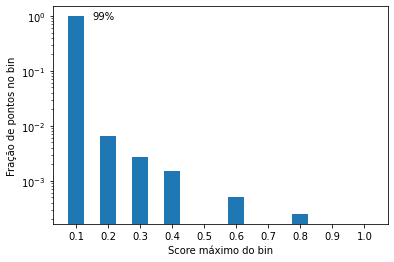

In [22]:
y_probs = model.predict_proba(X_test)[:,1]
x, y, p = calib_curve_proportions(y_test, y_probs, n_bins=10)
plt.bar(np.arange(0.1, 1.1, 0.1), p, width=0.05)
plt.yscale('log'); plt.ylabel("Fração de pontos no bin")
plt.xticks(np.arange(0.1, 1.1, 0.1)); plt.xlabel("Score máximo do bin")
plt.text(0.15, p[0]*0.90, f"{round(p[0]*100)}%")
plt.show()

99% dos scores são menores que 0.1. A maior parte dos bins está vazia, e métricas como ECE vão quebrar.

In [23]:
print("Modelo original")
print(stratified_brier_score(
    y_true=y_test, 
    y_probs=model.predict_proba(X_test)[:,1]
))
print("-"*30)
print("Model calibrado")
print(stratified_brier_score(
    y_true=y_test, 
    y_probs=model_calib.predict_proba(X_test)[:,1]
))
print("-"*30)

Modelo original
              1         0
Brier  0.796723  0.000482
------------------------------
Model calibrado
              1         0
Brier  0.723635  0.000802
------------------------------


O que percebemos aqui? O modelo original é muito bem calibrado na classe 0 e mal na classe 1, com o Brier score dela sendo 0.04% do Brier score da classe 1. 

O processo de calibração padrão de fato melhorou esse Brier score, em detrimento do da classe 0; porém, a diferença de qualidade de calibração entre as duas se mantém gritante.

### Com um modelo um pouco melhor (com pesos)

In [24]:
model = RandomForestClassifier(max_depth=8, random_state=1,
                               class_weight="balanced_subsample")\
                              .fit(X_train, y_train)
model_calib = CalibratedClassifierCV(model, cv='prefit', method='isotonic').fit(X_calib, y_calib)

In [25]:
print("ROC AUC (modelo com pesos): {0:.3f}".format(
    roc_auc_score(
        y_test, 
        model.predict_proba(X_test)[:,1])
))

ROC AUC (modelo com pesos): 0.838


Já percebemos que o modelo tem uma melhoria na performance, com aumento da ROC AUC. Vejamos os scores:

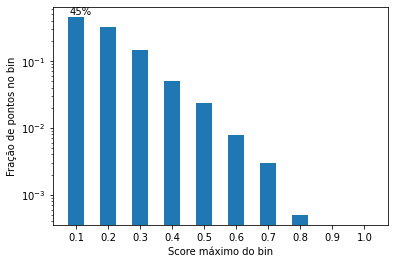

In [26]:
y_probs = model.predict_proba(X_test)[:,1]
x, y, p = calib_curve_proportions(y_test, y_probs, n_bins=10)
plt.bar(np.arange(0.1, 1.1, 0.1), p, width=0.05)
plt.yscale('log'); plt.ylabel("Fração de pontos no bin")
plt.xticks(np.arange(0.1, 1.1, 0.1)); plt.xlabel("Score máximo do bin")
plt.text(0.08, p[0]*1.1, f"{round(p[0]*100)}%")
plt.show()

Note que agora os scores se distribuem de forma mais uniforme entre os bins, apesar da maior parte ainda estar concentrado em scores baixos.

In [27]:
print("Modelo original")
print(stratified_brier_score(
    y_true=y_test, 
    y_probs=model.predict_proba(X_test)[:,1]
))
print("-"*30)
print("Model calibrado")
print(stratified_brier_score(
    y_true=y_test, 
    y_probs=model_calib.predict_proba(X_test)[:,1]
))
print("-"*30)

Modelo original
              1         0
Brier  0.413937  0.028966
------------------------------
Model calibrado
              1         0
Brier  0.710228  0.001229
------------------------------


Vemos que agora algo interessante acontece. O modelo original, adaptado ao caso desbalanceado, tem o melhor Brier score para a classe 1 que vimos até agora (e o pior para a classe 0); ao rodar a calibração, nós na verdade *pioramos* a calibração da classe 1 em favor da 0, simplesmente por causa do desbalanço!

### A estratégia de underbagging

In [38]:
from sklearn.base import BaseEstimator, ClassifierMixin

class BaggedCalibratedPredictor(BaseEstimator, ClassifierMixin):
    
    def __init__(self,
                 model,
                 target_balance=0.1,
                 bootstrap_samples=100,
                ):
        self.model = model
        self.target_balance = target_balance
        self.bootstrap_samples = bootstrap_samples
        
        self.trained = False
        
    def calibrate(self, X_calib, y_calib):
        
        calibrator_list = []
        for _ in range(self.bootstrap_samples):
            calibrator = CalibratedClassifierCV(base_estimator=self.model,
                                                cv='prefit', 
                                                method='isotonic')

            X_boot, y_boot = self._undersample_boostrap(X_calib, y_calib, 
                                                  target_balance=self.target_balance)
            calibrator.fit(X_boot, y_boot)
            calibrator_list.append(calibrator)

        self.calibrator_list = calibrator_list
        self.trained = True
        return self
    
    def predict_proba(self, X):
        
        if not self.trained:
            raise Exception("Calibrator not calibrated yet")
        
        results = []
        for calibrator in self.calibrator_list:
            results.append(calibrator.predict_proba(X))
        
        mean_pred = np.array(results).mean(axis=0)
        return mean_pred
    
    def predict(self, X):
        # Not implemented
        return None
    
    def _undersample_boostrap(self, X_calib, y_calib, target_balance=0.5):
    
        # separate positive and negative classes
        X1 = X_calib[y_calib==1]; n1 = len(X1)
        X0 = X_calib[y_calib==0]; n0 = len(X0)

        # undersample X0
        bs_indices = np.random.choice(np.arange(0,n0), 
                                size=int(n1*(1-target_balance)/target_balance),
                                replace=True)

        X0_u = X0[bs_indices]; n0_u = len(X0_u)

        # rebuild
        X_calib_u = np.concatenate([X1, X0_u])
        y_calib_u = np.concatenate([np.ones(n1), np.zeros(n0_u)])

        # shuffle - or should it be bootstrap ?
        indices = np.arange(0, len(X_calib_u))
        np.random.shuffle(indices)

        X_calib_u = X_calib_u[indices]
        y_calib_u = y_calib_u[indices]

        return X_calib_u, y_calib_u

Vamos usar isso para calibrar, focando na classe de minoria:

In [39]:
model = RandomForestClassifier(max_depth=8, random_state=1,
                               class_weight="balanced_subsample")\
                              .fit(X_train, y_train)

bagged_calib = BaggedCalibratedPredictor(model, 
                                         target_balance=0.3,
                                         bootstrap_samples=400)
bagged_calib.calibrate(X_calib, y_calib)

BaggedCalibratedPredictor(bootstrap_samples=400,
                          model=RandomForestClassifier(class_weight='balanced_subsample',
                                                       max_depth=8,
                                                       random_state=1),
                          target_balance=0.3)

In [40]:
stratified_brier_score(
    y_true=y_test, 
    y_probs=bagged_calib.predict_proba(X_test)[:,1]
)

,1,0
Brier,0.255308,0.061889


In [41]:
print("ROC AUC (modelo calibrado underbagged): {0:.3f}".format(
    roc_auc_score(
        y_test, 
        bagged_calib.predict_proba(X_test)[:,1])
))

ROC AUC (modelo calibrado underbagged): 0.836


Conseguimos agora sim ver uma grande melhoria! O Brier score da classe 1 está o mais baixo possível, com um sacrifício claro da calibração da classe 0. A ROC AUC é basicamente a mesma do modelo base.

### Quer dizer que sempre vale a pena usar underbagging?

Não. Novamente, vejamos a regressão logística:

In [42]:
# 3 modelos: base, calibrado normalmente, calibrado com underbagging
model = LogisticRegression(class_weight="balanced",
                           random_state=1).fit(X_train, y_train)
model_calib_naive = CalibratedClassifierCV(model, cv='prefit', method='isotonic').fit(X_calib, y_calib)
model_calib_underbag = BaggedCalibratedPredictor(model,
                                                 target_balance=0.3,
                                                 bootstrap_samples=400).calibrate(X_calib, y_calib)

# Resultados

df_base = stratified_brier_score(
    y_true=y_test, 
    y_probs=model.predict_proba(X_test)[:,1]
)
df_cal = stratified_brier_score(
    y_true=y_test, 
    y_probs=model_calib.predict_proba(X_test)[:,1]
)
df_bagcal = stratified_brier_score(
    y_true=y_test, 
    y_probs=bagged_calib.predict_proba(X_test)[:,1]
)
# join everything together
res = pd.concat([df_base, df_cal, df_bagcal])
res.index = index=['Original', 'Simple', 'Underbagged']
res

,1,0
Original,0.197718,0.207776
Simple,0.710228,0.001229
Underbagged,0.255308,0.061889


Vemos aqui que:
* O modelo original tem o melhor Brier score estratificado para a classe 1
* Calibração simples leva a melhora do Brier score da classe 0, dado o desbalanço
* Mesmo o underbagging não consegue voltar ao Brier score da classe 1 que o modelo base tem

Ou seja: aqui, também, a regressão logística se vira melhor sem calibração à posteriori.

## Conclusão / guia prático

1. Decida se calibração é importante para você
  * Se você somente precisa ordenar os pontos corretamente, calibração não importa muito
  
2. Se você decidir calibrar:
  * Além de conjuntos de treino e teste, sempre separe um conjunto para calibração
  * Garanta que esse conjunto seja grande o bastante, idealmente com 1000-2000 ou mais pontos
  * No caso de redes neurais ou regressão logística, é pouco provável que calibração tenha grandes efeitos - mas vale a pena checar
  * Modelos baseados em árvores, assim como SVM, se beneficiam de calibração. As curvas de calibração terão majoritariamente um formato em S
3. Se seu dataset é balanceado:
  * Para comparar modelos distintos: usar ECE / inspeção visual das curvas de calibração 
  * Para comparar um modelo com sua versão calibrada: usar ECE / Brier Score
  * Tente rodar calibração padrão via Scikit-Learn: `CalibratedClassifierCV` com `cv='prefit'` e `method='isotonic'` 
  
4. Se seu dataset é desbalanceado:
  * Treine o melhor modelo possível (muitas vezes passar `class_weight` ou `sample_weight` é o suficiente), focando em performance
  * Use Brier scores estratificados como métrica (para comparar um modelo com sua versão calibrada)
  * Calibração via undersampling+bagging (underbagging) com regressão isotônica deve ser uma boa escolha, especialmente para modelos baseados em árvores.

## Referências
[1] B. C. Wallace and I. J. Dahabreh, "Class Probability Estimates are Unreliable for Imbalanced Data (and How to Fix Them)," 2012 IEEE 12th International Conference on Data Mining, 2012, pp. 695-704, doi: 10.1109/ICDM.2012.115.

[2] Predicting Good Probabilities With Supervised Learning 
https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf

[3] Mahdi Pakdaman Naeini, Gregory F Cooper, and Milos Hauskrecht. 2015. “Obtaining Well Calibrated Probabilities Using Bayesian Binning.” In AAAI, Pp. 2901–2907.

[4] https://developers.google.com/machine-learning/crash-course/classification/prediction-bias

[5] Fawcett, T., Niculescu-Mizil, A. PAV and the ROC convex hull. Mach Learn 68, 97–106 (2007). https://doi.org/10.1007/s10994-007-5011-0

## Apêndices

### 1. ROC AUC e score KS são invariantes sob calibração; o average precision é quase!

A calibração é um procedimento que altera os scores preditos de forma monotônica, de forma que se temos dois scores $q_1 \geq q_2$ inicialmente, então a calibração $\phi$ deve satisfazer $\phi(q_1) \geq \phi(q_2)$: a ordem não se altera.

Isso significa que métricas como a **ROC AUC** ou o **score KS** (que somente dependem da *ordem* relativa dos scores) não são alteradas, e um modelo calibrado deve dar a mesma ROC AUC / KS do modelo original.



> Para ver isso, basta ver que a ROC AUC (também conhecida como estatística C) pode ser definida como $\mathbb P(X_1 \geq X_0)$ em que $X_1$ são os scores preditos para membros da classe 1, e $X_0$ são os scores da classe 0. Similarmente, o score KS depende somente da curva ROC, que também não se modifica sob calibração.

E o **average precision** (ie a área debaixo da curva de precision/recall)? Se o calcularmos de forma ingênua usando o Scikit-Learn, parece que ele é diferente:

In [48]:
from sklearn.metrics import average_precision_score

In [115]:
X, y = make_classification(n_samples=20000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10)

X_train, X_calib, X_test, y_train, y_calib, y_test = \
    train_calib_test_split(X, y,
                           train_size=0.6,
                           calib_size=0.15,
                           test_size=0.25,
                           random_state=42)

mod = LogisticRegression(random_state=2).fit(X_train, y_train)
mod_calib = CalibratedClassifierCV(base_estimator=mod, cv='prefit', method='isotonic').fit(X_calib, y_calib)

In [116]:
print("AP modelo base:", round(average_precision_score(y_test, mod.predict_proba(X_test)[:,1]),3))
print("AP calibrado  :", round(average_precision_score(y_test, mod_calib.predict_proba(X_test)[:,1]),3))

AP modelo base: 0.803
AP calibrado  : 0.785


Se usarmos a função `PrecisionRecallDisplay`, que mostra a curva de precision-recall e a Avg. Precision, vemos o porque disso:

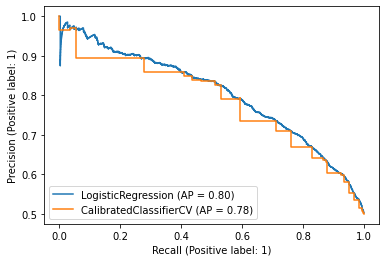

In [117]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(mod, X_test, y_test, ax=ax)
PrecisionRecallDisplay.from_estimator(mod_calib, X_test, y_test, ax=ax)
plt.show()

Por algum motivo, parece que temos uma função escada.

Na verdade, isso é um artifício gráfico. O que acontece é que o processo de calibrar um modelo efetivamente acaba tomando o fecho convexo (*convex hull* em inglês) dele na curva ROC (vide [5] para uma prova). O fecho convexo liga pontos da curva ROC com segmentos de reta, de forma a torná-la convexa. 

O Scikit-Learn não guarda a curva toda; ele somente mantém os vértices conectados por estes segmentos de reta. Ao mapear esses pontos para o plano PR(Precision/Recall), temos somente alguns pontos, e devido à geometria particular do plano PR, não podemos simplesmente conectá-los com retas.
> É possível provar, via teorema de Bayes, o seguinte fato. Sejam $(x,y)$ as coordenadas do plano ROC (ou seja, $x$ é a false positive rate e $y$ é a true positive rate). Seja também $d$ a taxa de desbalanço (por exemplo, se temos uma proporção de 1:2 entre a classe 1 e a classe 0, $d = 1/2$). Se chamarmos de $(x', y')$ as coordenadas no plano PR, com $x'$ sendo o recall e $y'$ sendo precision, então 
$$\begin{align*}
x' &= y\\
y' &= \frac{y}{y+ x/r}
\end{align*}$$
Retas no plano $(x,y)$ não são mapeadas em retas no plano $(x', y')$. Logo, não podemos simplesmente falar que a curva de precision/recall do modelo calibrado possa ser obtida por interpolação linear dos vértices.

Abaixo, resolvemos esse problema da seguinte forma:
* Calculamos a curva ROC do modelo calibrado
* Usamos `scipy.interpolate` para criar uma interpolação linear
* Amostramos vários pontos
* Passamos para o plano PR
* Usamos integração numérica para calcular a área sob a curva, ie. a Average Precision do modelo calibrado

In [118]:
def average_precision_improved(y_true, y_probs):
    from sklearn.metrics import auc, roc_curve
    from scipy.interpolate import interp1d
    
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    
    x = np.linspace(1e-8, 1-1e-8, 1000)
    y = interp1d(fpr, tpr)(x)
    d = y_true.mean()/(1-y_true.mean())

    rec  = y
    prec = y/(y + x/d)
    
    rec = np.append(rec[::-1], 0)[::-1]
    prec = np.append(prec[::-1], 1)[::-1]
    
    return rec, prec, auc(rec, prec)

In [119]:
rec, prec, ap = average_precision_improved(y_true=y_test,
                                              y_probs=mod_calib.predict_proba(X_test)[:,1])

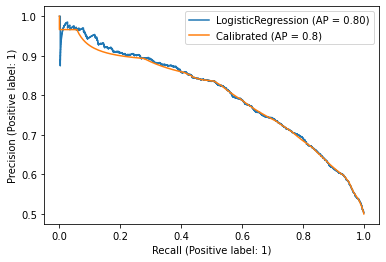

In [123]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(mod, X_test, y_test, ax=ax)
ax.plot(rec, prec, label=f'Calibrated (AP = {round(ap,2)})')
plt.legend()
plt.show()

Como vemos, a área é basicamente a mesma. Assim, não há problemas em utilizar a Avg. Precision do modelo original como proxy.